<a href="https://colab.research.google.com/github/rebeccadimatteo/FitDiary_FIA/blob/main/regressioneLineare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressione lineare multipla

## Ottenimento del dataset

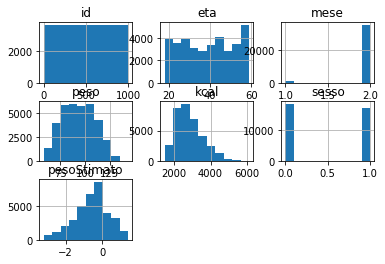

,id,eta,mese,peso,kcal,sesso,pesoStimato
0,1,46,1,67.00000,2061,0,-0.438622
1,1,46,2,67.43862,1537,0,-1.277814
2,1,46,2,68.71644,3173,0,0.399622
3,1,46,2,68.31682,2684,0,0.281297
4,1,46,2,68.03552,1568,0,-1.225765


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from six.moves import urllib

DOWNLOAD_ROOT="https://raw.githubusercontent.com/rebeccadimatteo/FitDiary_FIA/master/dataset.csv"

def fetch_file_data1(file_url1=DOWNLOAD_ROOT, file_path1="file"):
  os.makedirs(file_path1, exist_ok=True)
  csv_path1 = os.path.join(file_path1, "dataset.csv")
  urllib.request.urlretrieve(file_url1, csv_path1)
fetch_file_data1()

#df è la variabile che contiene il dataset
df=pd.read_csv("file/dataset.csv")
df=df[["id", "eta", "mese", "peso", "kcal", "sesso", "pesoStimato"]]
df.hist()
plt.show()
df.head(5)

## 1)DataCleaning

### 1.1) Descrizione del dataset

In [ ]:
df.describe()

,id,eta,mese,peso,kcal,sesso,pesoStimato
count,36000.000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000
mean,500.500,38.973000,1.972222,93.960686,2854.008639,0.481000,-0.577729
std,288.679,12.283911,0.164338,16.473259,739.296984,0.499646,0.931751
min,1.000,18.000000,1.000000,58.159405,1476.000000,0.000000,-3.196676
25%,250.750,28.000000,2.000000,80.624093,2294.000000,0.000000,-1.165279
50%,500.500,39.000000,2.000000,93.661348,2725.000000,0.000000,-0.487886
75%,750.250,49.000000,2.000000,106.744870,3285.250000,1.000000,0.000000
max,1000.000,59.000000,2.000000,143.593690,6117.000000,1.000000,1.402835


### 1.2) Verifica valori null nel dataset

In [ ]:
#verifica se ci sono dati null nel dataset
df.isnull().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

### 1.3) Verifica valori N/A nel dataset

In [ ]:
#verifica se ci sono dati NA nel dataset
df.isna().any()

id             False
eta            False
mese           False
peso           False
kcal           False
sesso          False
pesoStimato    False
dtype: bool

###1.4) Data Plot

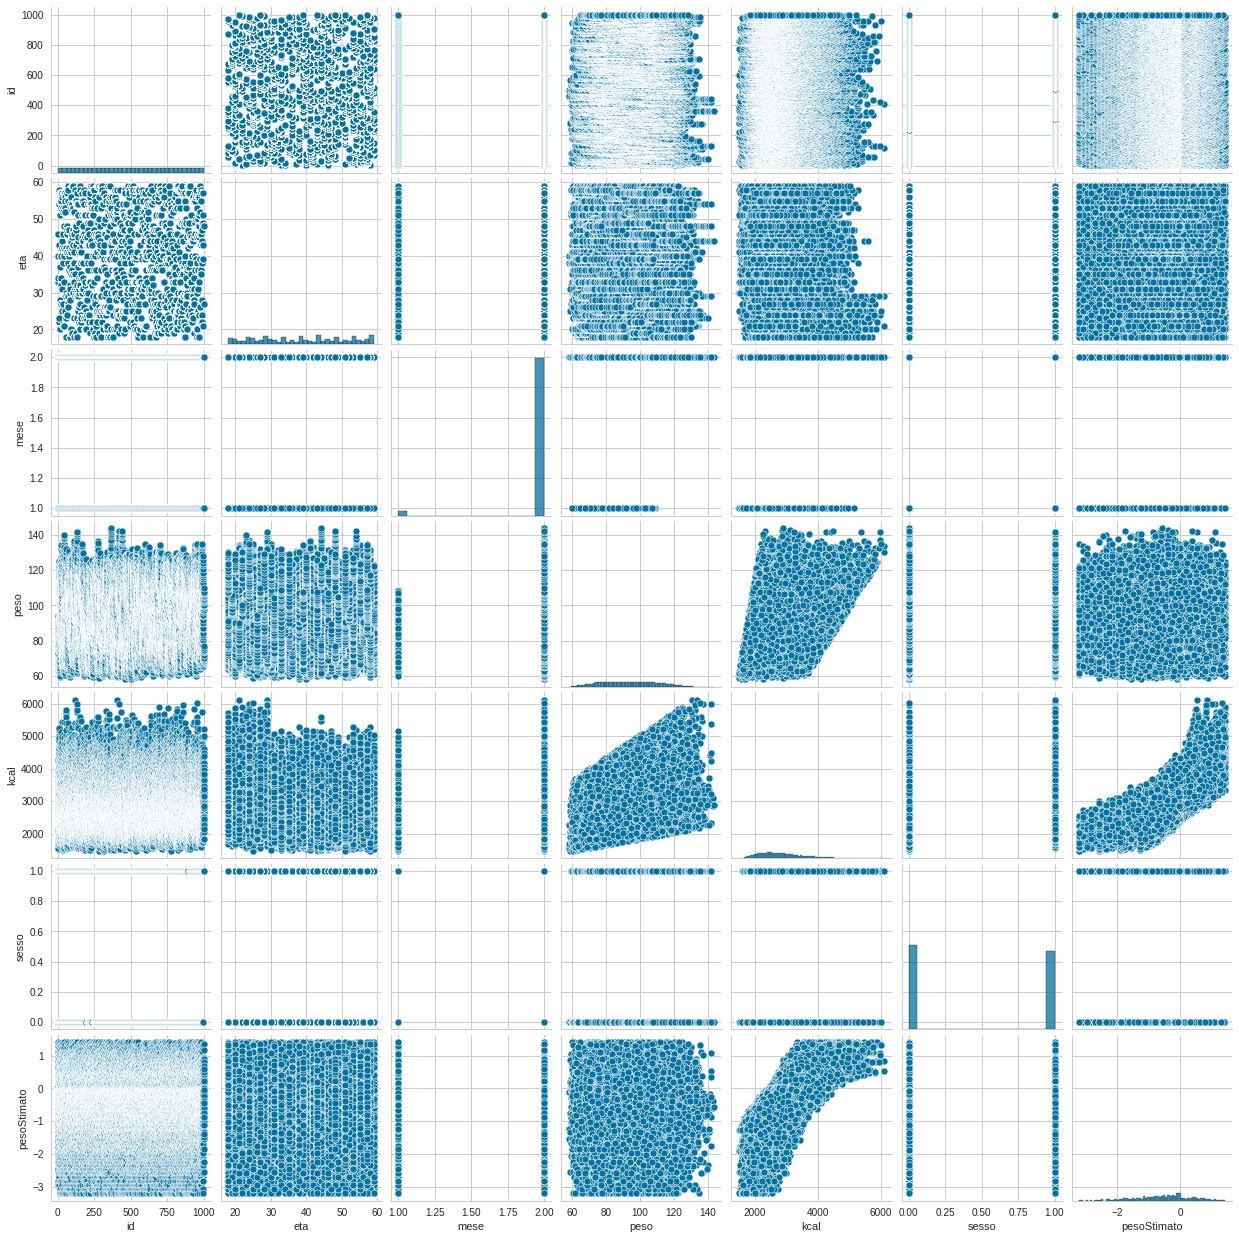

In [ ]:
import seaborn as sb
from matplotlib import style

style.use('seaborn-whitegrid')

plt.rcParams['figure.figsize'] = (20,10)

sb.pairplot(df)

plt.savefig('pairplor.png')

###1.5) Plot Linearità e Multicollinearità

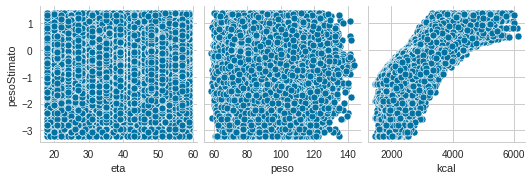

In [ ]:
sb.pairplot(df,x_vars=["eta", "peso", "kcal"], y_vars=["pesoStimato"])

plt.savefig('linearPlot.png')

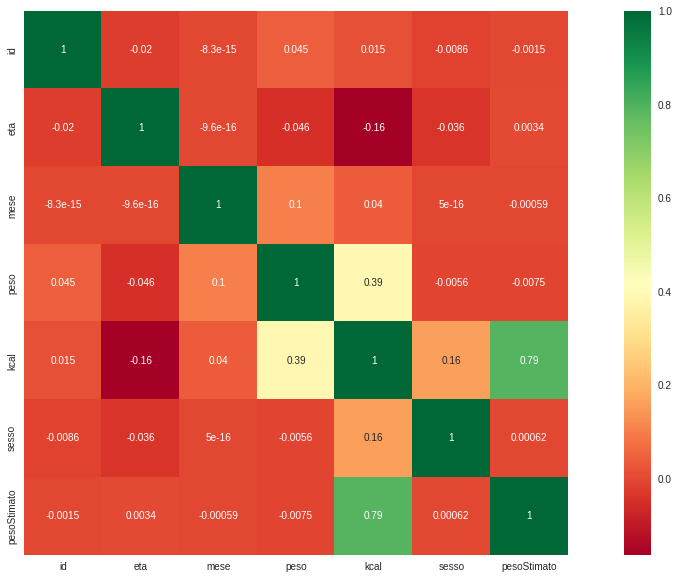

In [ ]:

sb.heatmap(df.corr(), annot=True, cmap="RdYlGn", square=True)

## 2)Divisione in Training e Test Sets, Feature Selection

### 2.1) Istanziazione funzioni per Regressione

In [2]:
from sklearn import model_selection
from yellowbrick.base import Visualizer
from re import M
from sklearn.model_selection import RepeatedKFold, KFold
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from termcolor import colored as cl
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.compat import lzip
import matplotlib.pyplot as plt
import copy

#oggetto che contiene le metriche
class Metrics1:
  #costruttore
  def __init__(self,mae,mse,rmse,model):
    self.mae=mae
    self.mse=mse
    self.rmse=rmse
    self.model=model
  
  #ToString
  def __str__(self):
    return f'Metrics [mae= {self.mae} mse= {self.mse} rmse= {self.rmse} mean= {np.mean([self.mae,self.mse,self.rmse])}'

class MetricsResultContainer:
  meanMAE = []
  meanMSE = []
  meanRMSE = []
  #costruttore
  def __init__(self,model,alg,scaler,param,metricsMean):
    self.model=model
    self.alg=alg
    self.scaler=scaler
    self.param=param
    self.metricsMean=metricsMean
    self.meanMAE = []
    self.meanMSE = []
    self.meanRMSE = []
  
  def printMetrics(self):
    for m in self.metricsMean:
      self.meanMAE.append(m.mae)
      self.meanMSE.append(m.mse)
      self.meanRMSE.append(m.rmse)
    print("meanMAE=",np.mean(self.meanMAE))    
    print("meanMSE=",np.mean(self.meanMSE))    
    print("meanRMSE=",np.mean(self.meanRMSE))

def generateModel(alg, scaler, model, select):
  #array di metriche (MAE,MSE,RMSE)
  metrics1 = []
  #generazione n_split test/trainig sets
  
  for train_index, test_index in alg.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #feature scaling sui traing test
    X_train_z = scaler.fit_transform(X_train)
    X_test_z = scaler.transform(X_test)
    #applicazione feature scaling su train_z
    X_train_z = select.fit_transform(X_train_z, y_train)
    X_test_z = select.transform(X_test_z)
    
    #training dell'algoritmo sui training set
    model.fit(X_train_z,y_train)
    #validazione modello e applicazione predizione sui testSet
    y_pred = model.predict(X_test_z)
    modelCopy = copy.copy(model)
    #calcolo metriche predizione
    metrics1.append(Metrics1(metrics.mean_absolute_error(y_test,y_pred),
                            metrics.mean_squared_error(y_test,y_pred),
                            np.sqrt(metrics.mean_squared_error(y_test,y_pred)),
                            modelCopy))
    
  #array medie degli errori kf
  meanMAE = []
  meanMSE = []
  meanRMSE = []

  #calcolo singole medie degli errori kf
  for m in metrics1:
    meanMAE.append(m.mae)
    meanMSE.append(m.mse)
    meanRMSE.append(m.rmse)
    

  print("meanMAE=",np.mean(meanMAE))    
  print("meanMSE=",np.mean(meanMSE))    
  print("meanRMSE=",np.mean(meanRMSE))

  return metrics1

#Scelta variabile dipendente (y) e indipendenti (X)
X=df.drop(columns='pesoStimato')
y=df.pesoStimato
#numero record nel dataset
k=len(df)
#calcolo k ideale da usare nelle tecniche di validazione
k= (k/(k*0.3))
#Kf con k gruppi
kf = KFold(n_splits=int(np.ceil(k)),random_state=42, shuffle=True)
#rKf con k gruppi, e 10 ripetizioni
rkf = RepeatedKFold(n_splits=int(np.ceil(k)), n_repeats=10, random_state=42)
#rkf con 3 gruppi e 10 ripetizioni per questioni della ram del coso
rkfRF = RepeatedKFold(n_splits=3, n_repeats=10, random_state=42)
#instanziazione algritmo per selezione dei KBest individui
select = SelectKBest(f_regression, k=4)
#risultati: array di array di metriche
metricsResults = []

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 2.2) Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
print("Linear Regression - ZScore Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Linear Regression","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  LinearRegression(), select)
  )
)
print("\nLinear Regression - ZScore Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Linear Regression","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  LinearRegression(), select)
  )
)
print("\nLinear Regression - MinMax Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Linear Regression","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  LinearRegression(), select)
  )
)
print("\nLinear Regression - MinMax Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Linear Regression","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  LinearRegression(), select)
  )
)
print("\nLinear Regression - RobustScaler Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Linear Regression","KF","RobustScaler","Default",
    generateModel(kf, RobustScaler(),  LinearRegression(), select)
  )
)
print("\nLinear Regression - RobustScaler Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Linear Regression","RKF","RobustScaler","Default",
    generateModel(rkf, RobustScaler(), LinearRegression(), select)
  )
)


Linear Regression - ZScore Normalization - KF
meanMAE= 0.362287358485174
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637

Linear Regression - ZScore Normalization - RKF
meanMAE= 0.3506286065200122
meanMSE= 0.20548739801914911
meanRMSE= 0.4525625986029024

Linear Regression - MinMax Normalization - KF
meanMAE= 0.36228735848517396
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637

Linear Regression - MinMax Normalization - RKF
meanMAE= 0.3506286065200122
meanMSE= 0.20548739801914911
meanRMSE= 0.4525625986029024

Linear Regression - RobustScaler Normalization - KF
meanMAE= 0.362287358485174
meanMSE= 0.21890022759859026
meanRMSE= 0.4654735026786637

Linear Regression - RobustScaler Normalization - RKF
meanMAE= 0.35062860652001226
meanMSE= 0.20548739801914911
meanRMSE= 0.4525625986029024


## 2.3) DecisionTree Regression

In [ ]:
from sklearn.tree import DecisionTreeRegressor
print("DecisionTreeRegressor - ZScore Normalization - KF")
metricsResults.append(
  MetricsResultContainer("DecisionTree Regression","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  DecisionTreeRegressor(), select)
  )
)

print("\nDecisionTreeRegressor - ZScore Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("DecisionTree Regression","RKF","ZScore","Default",
    generateModel(rkf, StandardScaler(),  DecisionTreeRegressor(), select)
  )
)

print("\nDecisionTreeRegressor - MinMax Normalization - KF")
metricsResults.append(
  MetricsResultContainer("DecisionTree Regression","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  DecisionTreeRegressor(), select)
  )
)

print("\nDecisionTreeRegressor - MinMax Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("DecisionTree Regression","RKF","MinMax","Default",
    generateModel(rkf, MinMaxScaler(),  DecisionTreeRegressor(), select)
  )
)

print("\nDecisionTreeRegressor - RobustScaler Normalization - KF")
metricsResults.append(
  MetricsResultContainer("DecisionTree Regression","KF","Robust","Default",
    generateModel(kf, RobustScaler(),  DecisionTreeRegressor(), select)
  )
)

print("\nDecisionTreeRegressor - RobustScaler Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("DecisionTree Regression","RKF","Robust","Default",
    generateModel(rkf, RobustScaler(), DecisionTreeRegressor(), select)
  )
)


DecisionTreeRegressor - ZScore Normalization - KF
meanMAE= 0.38100916245277777
meanMSE= 0.30038362781266104
meanRMSE= 0.544573500900941

DecisionTreeRegressor - ZScore Normalization - RKF
meanMAE= 0.3774172775177875
meanMSE= 0.2922828090972686
meanRMSE= 0.5389771751478086

DecisionTreeRegressor - MinMax Normalization - KF
meanMAE= 0.38123402568927783
meanMSE= 0.30124362026662427
meanRMSE= 0.5454657435825445

DecisionTreeRegressor - MinMax Normalization - RKF
meanMAE= 0.3775590752452555
meanMSE= 0.2924318432555776
meanRMSE= 0.5391185155433613

DecisionTreeRegressor - RobustScaler Normalization - KF
meanMAE= 0.38125418587677784
meanMSE= 0.29980925400921327
meanRMSE= 0.5440631574069674

DecisionTreeRegressor - RobustScaler Normalization - RKF
meanMAE= 0.3775281413065083
meanMSE= 0.29256276993432756
meanRMSE= 0.5392090990050077


##2.4) Random Forest Regression

In [ ]:
from sklearn.ensemble import RandomForestRegressor

print("RandomForestRegressor - ZScore Normalization - KF")
metricsResults.append(
  MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
    generateModel(kf, StandardScaler(),  RandomForestRegressor(), select)
  )
)

print("\nRandomForestRegressor - ZScore Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
    generateModel(rkfRF, StandardScaler(),  RandomForestRegressor(), select)
  )
)

print("\nRandomForestRegressor - MinMax Normalization - KF")
metricsResults.append(
  MetricsResultContainer("RandomForest Regression","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  RandomForestRegressor(), select)
  )
)

print("\nRandomForestRegressor- MinMax Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("RandomForest Regression","RKF","MinMax","Default",
    generateModel(rkfRF, MinMaxScaler(),  RandomForestRegressor(), select)
  )
)

print("\nRandomForestRegressor - RobustScaler Normalization - KF")
metricsResults.append(
  MetricsResultContainer("RandomForest Regression","KF","Robust","Default",
    generateModel(kf, RobustScaler(),  RandomForestRegressor(), select)
  )
)

print("\nRandomForestRegressor - RobustScaler Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("RandomForest Regression","RKF","Robust","Default",
    generateModel(rkfRF, RobustScaler(), RandomForestRegressor(), select)
  )
)


RandomForestRegressor - ZScore Normalization - KF
meanMAE= 0.29967828748926495
meanMSE= 0.1689420786775212
meanRMSE= 0.40874891776729794

RandomForestRegressor - ZScore Normalization - RKF
meanMAE= 0.2978910890328251
meanMSE= 0.16611338489552976
meanRMSE= 0.40549327933292556

RandomForestRegressor - MinMax Normalization - KF
meanMAE= 0.2994682766078948
meanMSE= 0.16881619219846083
meanRMSE= 0.40858401587520166

RandomForestRegressor- MinMax Normalization - RKF


##2.5) SVR Regression

In [ ]:
from sklearn.svm import SVR
print("SVR - ZScore Normalization - KF")
metricsResults.append(
  MetricsResultContainer("SVR Regression","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  SVR(), select)
  )
)

print("\nSVR - ZScore Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("SVR Regression","RKF","ZScore","Default",
    generateModel(rkfRF, StandardScaler(),  SVR(), select)
  )
)

print("\nSVR - MinMax Normalization - KF")
metricsResults.append(
  MetricsResultContainer("SVR Regression","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  SVR(), select)
  )
)

print("\nSVR- MinMax Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("SVR Regression","RKF","MinMax","Default",
    generateModel(rkfRF, MinMaxScaler(),  SVR(), select)
  )
)

print("\nSVR - RobustScaler Normalization - KF")
metricsResults.append(
  MetricsResultContainer("SVR Regression","KF","Robust","Default",
    generateModel(kf, RobustScaler(),  SVR(), select)
  )
)

print("\nSVR - RobustScaler Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("SVR Regression","RKF","Robust","Default",
    generateModel(rkfRF, RobustScaler(), SVR(), select)
  )
)

\SVR - ZScore Normalization - KF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


meanMAE= 0.3011121529135539
meanMSE= 0.167708111742047
meanRMSE= 0.4046325628068693
\SVR - ZScore Normalization - RKF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


meanMAE= 0.2894368562232225
meanMSE= 0.15377522163148988
meanRMSE= 0.39014497010394433
\SVR - MinMax Normalization - KF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


meanMAE= 0.30289593050668523
meanMSE= 0.1687865019667145
meanRMSE= 0.40605287399966683
\SVR- MinMax Normalization - RKF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


meanMAE= 0.29091290669928255
meanMSE= 0.15426622217998784
meanRMSE= 0.3908045080349631
\SVR - RobustScaler Normalization - KF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


meanMAE= 0.30122686071265414
meanMSE= 0.16782727299860584
meanRMSE= 0.40477215252783993
\SVR - RobustScaler Normalization - RKF


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


meanMAE= 0.2893599993606667
meanMSE= 0.15377708484810546
meanRMSE= 0.3901640073214808


## 2.6) Lasso Regression

In [ ]:
from sklearn import linear_model
lassoReg = linear_model.Lasso()
print("Lasso Regression - ZScore Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Lasso Regression","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  lassoReg, select)
  )
)

print("\nLasso Regression - ZScore Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Lasso Regression","RKF","ZScore","Default",
    generateModel(rkfRF, StandardScaler(),  lassoReg, select)
  )
)

print("\nLasso Regression - MinMax Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Lasso Regression","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  lassoReg, select)
  )
)

print("\nLasso Regression - MinMax Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Lasso Regression","RKF","MinMax","Default",
    generateModel(rkfRF, MinMaxScaler(),  lassoReg, select)
  )
)

print("\nLasso Regression - RobustScaler Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Lasso Regression","KF","Robust","Default",
    generateModel(kf, RobustScaler(),  lassoReg, select)
  )
)

print("\nLasso Regression - RobustScaler Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Lasso Regression","RKF","Robust","Default",
    generateModel(rkfRF, RobustScaler(), lassoReg, select)
  )
)

Lasso Regression - ZScore Normalization - KF
meanMAE= 0.7421048386407003
meanMSE= 0.8683396556240504
meanRMSE= 0.9318309634156843

Lasso Regression - ZScore Normalization - RKF
meanMAE= 0.742041334577572
meanMSE= 0.8681966764717224
meanRMSE= 0.9317504768019191

Lasso Regression - MinMax Normalization - KF
meanMAE= 0.7421048386407003
meanMSE= 0.8683396556240504
meanRMSE= 0.9318309634156843

Lasso Regression - MinMax Normalization - RKF
meanMAE= 0.7420377327132404
meanMSE= 0.8681917376213717
meanRMSE= 0.9317573199546523

Lasso Regression - RobustScaler Normalization - KF
meanMAE= 0.7421048386407003
meanMSE= 0.8683396556240504
meanRMSE= 0.9318309634156843

Lasso Regression - RobustScaler Normalization - RKF
meanMAE= 0.7420377327132404
meanMSE= 0.8681917376213717
meanRMSE= 0.9317573199546523


## 2.7) Ridge Regression

In [4]:
from sklearn import linear_model
bridgeReg = linear_model.Ridge()
print("Ridge Regression - ZScore Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Ridge Regression","KF","ZScore","Default",
    generateModel(kf, StandardScaler(),  bridgeReg, select)
  )
)

print("\nRidge Regression - ZScore Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Ridge Regression","RKF","ZScore","Default",
    generateModel(rkfRF, StandardScaler(),  bridgeReg, select)
  )
)

print("\nRidge Regression - MinMax Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Ridge Regression","KF","MinMax","Default",
    generateModel(kf, MinMaxScaler(),  bridgeReg, select)
  )
)

print("\nRidge Regression - MinMax Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Ridge Regression","RKF","MinMax","Default",
    generateModel(rkfRF, MinMaxScaler(),  bridgeReg, select)
  )
)

print("\nRidge Regression - RobustScaler Normalization - KF")
metricsResults.append(
  MetricsResultContainer("Ridge Regression","KF","Robust","Default",
    generateModel(kf, RobustScaler(),  bridgeReg, select)
  )
)

print("\nRidge Regression - RobustScaler Normalization - RKF")
metricsResults.append(
  MetricsResultContainer("Ridge Regression","RKF","Robust","Default",
    generateModel(rkfRF, RobustScaler(), bridgeReg, select)
  )
)

Ridge Regression - ZScore Normalization - KF
meanMAE= 0.3622863995118982
meanMSE= 0.21890028427450597
meanRMSE= 0.4654735558202294

Ridge Regression - ZScore Normalization - RKF
meanMAE= 0.34988636145221824
meanMSE= 0.2057749883320716
meanRMSE= 0.4527330976753359

Ridge Regression - MinMax Normalization - KF
meanMAE= 0.36224499209941846
meanMSE= 0.2189047984907513
meanRMSE= 0.46547831677488316

Ridge Regression - MinMax Normalization - RKF
meanMAE= 0.3498405478758688
meanMSE= 0.20577849280952873
meanRMSE= 0.45273678473601214

Ridge Regression - RobustScaler Normalization - KF
meanMAE= 0.36228597057173867
meanMSE= 0.2189003206697656
meanRMSE= 0.46547357929150157

Ridge Regression - RobustScaler Normalization - RKF
meanMAE= 0.3498859052534308
meanMSE= 0.20577503683488707
meanRMSE= 0.4527331382020928
